<a href="https://colab.research.google.com/github/ajrodriguezo/Calculadora-de-reposicionamientos-/blob/main/Copia_de_Copia_de_prueba2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Imports needed for the script
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.metrics import mean_squared_error


In [ ]:
Db= pd.read_excel("/content/prueba edad.xlsx")
Db.head()

,Edad,IMC,Total_Mov
0,18,20.26,9
1,18,24.40,21
2,19,16.30,1
3,19,20.00,8
4,20,39.68,1


In [ ]:
X= [Db.Edad,Db.IMC]
X = np.array(X)
y = Db.Total_Mov
y = y.values

In [ ]:
np.shape(X), np.shape(y)

((2, 180), (180,))

In [ ]:
X = X.swapaxes(1,0)
np.shape(X), np.shape(y)

((180, 2), (180,))

In [ ]:
clf = tree.DecisionTreeRegressor(max_depth=15)
clf = clf.fit(X, y)

In [ ]:
feature_names= ["Edad","IMC"]

In [ ]:
text_representation = tree.export_text(clf, feature_names= ["Edad","IMC"])
print(text_representation)


|--- Edad <= 67.50
|   |--- IMC <= 29.15
|   |   |--- IMC <= 28.30
|   |   |   |--- IMC <= 26.25
|   |   |   |   |--- IMC <= 17.15
|   |   |   |   |   |--- Edad <= 20.00
|   |   |   |   |   |   |--- value: [1.00]
|   |   |   |   |   |--- Edad >  20.00
|   |   |   |   |   |   |--- value: [8.00]
|   |   |   |   |--- IMC >  17.15
|   |   |   |   |   |--- IMC <= 17.30
|   |   |   |   |   |   |--- value: [25.00]
|   |   |   |   |   |--- IMC >  17.30
|   |   |   |   |   |   |--- Edad <= 31.50
|   |   |   |   |   |   |   |--- IMC <= 24.25
|   |   |   |   |   |   |   |   |--- Edad <= 29.50
|   |   |   |   |   |   |   |   |   |--- Edad <= 21.50
|   |   |   |   |   |   |   |   |   |   |--- IMC <= 19.75
|   |   |   |   |   |   |   |   |   |   |   |--- value: [1.00]
|   |   |   |   |   |   |   |   |   |   |--- IMC >  19.75
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 3
|   |   |   |   |   |   |   |   |   |--- Edad >  21.50
|   |   |   |   |   |   |   |   |   |   |--- 

In [ ]:
from sklearn.tree import _tree

def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    feature_names = [f.replace(" ", "_")[:-5] for f in feature_names]
    print("def predict({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "    " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, np.round(threshold,2)))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if {} > {}".format(indent, name, np.round(threshold,2)))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, tree_.value[node]))

    recurse(0, 1)

In [ ]:
tree_to_code(clf,feature_names= ["Edad","IMC"])

def predict(, ):
    if Edad <= 67.5:
        if IMC <= 29.15:
            if IMC <= 28.3:
                if IMC <= 26.25:
                    if IMC <= 17.15:
                        if Edad <= 20.0:
                            return [[1.]]
                        else:  # if Edad > 20.0
                            return [[8.]]
                    else:  # if IMC > 17.15
                        if IMC <= 17.3:
                            return [[25.]]
                        else:  # if IMC > 17.3
                            if Edad <= 31.5:
                                if IMC <= 24.25:
                                    if Edad <= 29.5:
                                        if Edad <= 21.5:
                                            if IMC <= 19.75:
                                                return [[1.]]
                                            else:  # if IMC > 19.75
                                                if IMC <= 22.18:
                                

In [ ]:
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if "
        
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += " then "
        if class_names is None:
            rule += "response: "+str(np.round(path[-1][0][0][0],3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),2)}%)"
        rule += f" | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules

In [ ]:
rules = get_rules(clf, feature_names, None )
for r in rules:
    print(r)

if (Edad <= 67.5) and (IMC <= 29.15) and (IMC <= 28.3) and (IMC <= 26.25) and (IMC > 17.15) and (IMC > 17.3) and (Edad > 31.5) and (IMC > 20.9) and (IMC <= 24.45) and (Edad > 35.5) and (Edad <= 64.0) and (Edad <= 58.5) and (Edad <= 57.5) and (IMC <= 22.5) and (IMC > 21.55) then response: 7.667 | based on 6 samples
if (Edad <= 67.5) and (IMC <= 29.15) and (IMC <= 28.3) and (IMC <= 26.25) and (IMC > 17.15) and (IMC > 17.3) and (Edad > 31.5) and (IMC > 20.9) and (IMC <= 24.45) and (Edad > 35.5) and (Edad <= 64.0) and (Edad <= 58.5) and (Edad <= 57.5) and (IMC > 22.5) and (IMC <= 24.35) then response: 10.833 | based on 6 samples
if (Edad <= 67.5) and (IMC <= 29.15) and (IMC <= 28.3) and (IMC <= 26.25) and (IMC > 17.15) and (IMC > 17.3) and (Edad > 31.5) and (IMC > 20.9) and (IMC > 24.45) and (IMC > 24.55) and (Edad <= 58.5) and (IMC > 25.15) and (Edad > 41.5) and (Edad > 46.5) and (Edad <= 57.0) then response: 10.8 | based on 5 samples
if (Edad <= 67.5) and (IMC <= 29.15) and (IMC <= 28.3)

In [ ]:
#y_hat = clf.predict([[1,84, 25]])
#y_hat
y_hat = clf.predict(X)

In [ ]:
y[0:70], y_hat[0:70]

(array([ 9, 21,  1,  8,  1, 10,  7,  8, 25,  1, 16, 14,  6, 16, 10,  0,  6,
        18, 27, 11,  5,  1,  8,  7, 20,  9,  5, 12,  7,  8, 10, 10,  8,  9,
        16, 29,  8, 11, 16,  5, 15, 12, 12,  3, 18, 11,  1, 13,  6, 11, 10,
         8,  4,  7,  4, 11,  8,  6, 14, 19,  6,  9, 12,  8,  6, 12, 10, 10,
        14,  1]),
 array([ 9.        , 21.        ,  1.        ,  8.        ,  1.        ,
        10.        ,  7.        ,  8.        , 25.        ,  1.        ,
        16.        , 14.        ,  6.        , 16.        , 10.        ,
         0.        ,  6.        , 18.        , 27.        , 11.        ,
         5.        ,  1.        ,  8.        ,  7.        , 20.        ,
         9.        ,  5.        , 12.        ,  7.        ,  8.        ,
        10.        , 10.        ,  8.        ,  9.        , 16.        ,
        29.        ,  8.        , 11.        , 16.        ,  5.        ,
        15.        , 12.        ,  7.5       ,  7.5       , 18.        ,
        11.5       , 

In [ ]:
#y_hat = clf.predict([[1,84, 25]])
#y_hat
y_hat = clf.predict(X)

In [ ]:
mean_squared_error(y, y_hat)

0.6966666666666667

[Text(0.7847214553886925, 0.96875, 'X[0] <= 67.5\nsquared_error = 28.926\nsamples = 180\nvalue = 9.961'),
 Text(0.6401142888692579, 0.90625, 'X[1] <= 29.15\nsquared_error = 29.148\nsamples = 164\nvalue = 10.329'),
 Text(0.47855013250883394, 0.84375, 'X[1] <= 28.3\nsquared_error = 32.08\nsamples = 127\nvalue = 10.85'),
 Text(0.35175574204946997, 0.78125, 'X[1] <= 26.25\nsquared_error = 30.063\nsamples = 120\nvalue = 10.558'),
 Text(0.16177120141342757, 0.71875, 'X[1] <= 17.15\nsquared_error = 32.81\nsamples = 91\nvalue = 11.121'),
 Text(0.147636925795053, 0.65625, 'X[0] <= 20.0\nsquared_error = 9.188\nsamples = 4\nvalue = 6.25'),
 Text(0.14056978798586572, 0.59375, 'squared_error = 0.0\nsamples = 1\nvalue = 1.0'),
 Text(0.15470406360424027, 0.59375, 'squared_error = 0.0\nsamples = 3\nvalue = 8.0'),
 Text(0.17590547703180212, 0.65625, 'X[1] <= 17.3\nsquared_error = 32.755\nsamples = 87\nvalue = 11.345'),
 Text(0.16883833922261485, 0.59375, 'squared_error = 0.0\nsamples = 1\nvalue = 25.0'

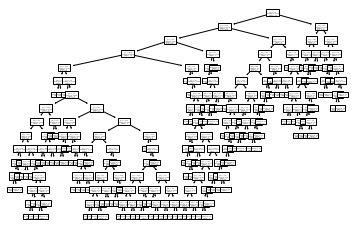

In [ ]:
# exportar el modelo a archivo .dot
with open(r"tree1.dot", 'w') as f:
     f = tree.export_graphviz(clf,
                              out_file=f,
                              max_depth = 5,
                              impurity = True,
                              rounded = True,
                              filled= True )
        
# Convertir el archivo .dot a png para poder visualizarlo
#check_call(['dot','-Tpng',r'tree1.dot','-o',r'tree1.png'])
#PImage("tree1.png")
tree.plot_tree(clf)

In [ ]:
y_hat = clf.predict([[18,23]])
y_hat

array([7.])